# Parameterized inference from multidimensional data

Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016.

For the sake of the illustration, we will assume 5-dimensional feature $\mathbf{x}$ generated
from the following process $p_0$:

 - $\mathbf{z} := (z_0, z_1, z_2, z_3, z_4)$, such that 
     $z_0 \sim {\cal N}(\mu=\alpha, \sigma=1)$,
     $z_1 \sim {\cal N}(\mu=\beta, \sigma=3)$,
     $z_2 \sim {\text{Mixture}}(\frac{1}{2}\,{\cal N}(\mu=-2, \sigma=1), \frac{1}{2}\,{\cal N}(\mu=2, \sigma=0.5))$,
     $z_3 \sim {\text{Exponential}(\lambda=3)}$, and
     $z_4 \sim {\text{Exponential}(\lambda=0.5)}$;
   
 - $\mathbf{x} := R  \mathbf{z}$, where $R$ is a fixed semi-positive definite $5 \times 5$ matrix defining a fixed projection of $\mathbf{z}$ into the observed space.
  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

import numpy as np
import theano
from scipy.stats import chi2

In [4]:
import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

In [5]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

# Parameters
true_A = 1.
true_B = -1.
A = theano.shared(true_A, name="A")
B = theano.shared(true_B, name="B")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=B, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Define p1 at fixed arbitrary value theta1 := 0,0
p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Draw data
X_true = p0.rvs(500, random_state=314) 

INFO (theano.gof.compilelock): Waiting for existing lock by process '1161' (I am process '10930')
INFO:theano.gof.compilelock:Waiting for existing lock by process '1161' (I am process '10930')
INFO (theano.gof.compilelock): To manually release the lock, delete /afs/cern.ch/user/j/jpavezse/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.3.1611-Core-x86_64-2.7.5-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /afs/cern.ch/user/j/jpavezse/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.3.1611-Core-x86_64-2.7.5-64/lock_dir


In [6]:
# Projection operator
print(R)

[[ 1.31229955  0.10499961  0.48310515 -0.3249938  -0.26387927]
 [ 0.10499961  1.15833058 -0.55865473  0.25275522 -0.39790775]
 [ 0.48310515 -0.55865473  2.25874579 -0.52087938 -0.39271231]
 [-0.3249938   0.25275522 -0.52087938  1.4034925  -0.63521059]
 [-0.26387927 -0.39790775 -0.39271231 -0.63521059  1.        ]]


In [7]:
# Plot the data
import corner
fig = corner.corner(X_true, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])
#plt.savefig("fig3.pdf")

ImportError: No module named corner

## Exact likelihood setup

In [8]:
# Minimize the exact LR
from scipy.optimize import minimize

def nll_exact(theta, X):
    A.set_value(theta[0])
    B.set_value(theta[1])
    return (p0.nll(X) - p1.nll(X)).sum()

r = minimize(nll_exact, x0=[0, 0], args=(X_true,))
exact_MLE = r.x

print("Exact MLE =", exact_MLE)

('Exact MLE =', array([ 1.01185167, -0.92213119]))


In [11]:
# Exact contours
A.set_value(true_A)
B.set_value(true_B)

bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16),
          (exact_MLE[1] - 0.5, exact_MLE[1] + 0.5)]

As = np.linspace(bounds[0][0], bounds[0][1], 100)
Bs = np.linspace(bounds[1][0], bounds[1][1], 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1), BB.reshape(-1, 1)))

exact_contours = np.zeros(len(X))

i = 0
for a in As:
    for b in Bs:
        exact_contours[i] = nll_exact([a, b], X_true)
        i += 1
        
exact_contours = 2. * (exact_contours - r.fun)

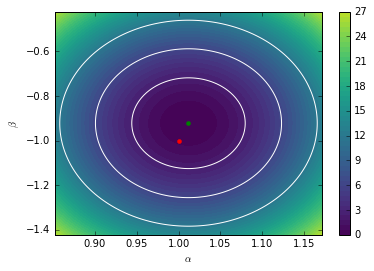

In [13]:
plt.contour(As, Bs, exact_contours.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, exact_contours.reshape(AA.shape).T, 50, vmin=0, vmax=30)
cb = plt.colorbar()

plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([exact_MLE[0]], [exact_MLE[1]], "g.", markersize=8)
#plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)

plt.axis((bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")

#plt.savefig("fig4a.pdf")
plt.show()

## Likelihood-free setup

In this example we will build a parametrized classifier $s(x; \theta_0, \theta_1)$ with $\theta_1$ fixed to $(\alpha=0, \beta=0)$.

In [14]:
# Build classification data
from carl.learning import make_parameterized_classification

bounds = [(-3, 3), (-3, 3)]

X, y = make_parameterized_classification(
    p0, p1,
    1000000, 
    [(A, np.linspace(*bounds[0], num=30)), 
     (B, np.linspace(*bounds[1], num=30))],
    random_state=1)

In [15]:
# Train parameterized classifier
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=0))),
    [A, B])
clf.fit(X, y)

ParameterizedClassifier(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(...
       shuffle=True, tol=1e-06, validation_fraction=0.1, verbose=False,
       warm_start=False)))]),
            params=[A, B])

For the scans and Bayesian optimization we construct two helper functions.

In [16]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0):    
    print(theta)
    
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X0 = p0.rvs(n_samples=250000)
    X1 = p1.rvs(n_samples=250000, random_state=random_state)
    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)
    
    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true, log=True)
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)    
            
    return value

In [17]:
from GPyOpt.methods import BayesianOptimization
bounds = [(-3, 3), (-3, 3)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.47111505  0.71393465]
[-2.61223671 -1.3609727 ]
[ 2.50655836 -2.16534926]
[-1.70116513 -0.50584613]
[-2.73957137 -2.27877443]
[ 2.21782966 -0.6521042 ]
[ 0.97245485  3.        ]
[ 1.00668876  1.27350047]
[-1.10420305  3.        ]
[ 1.0132659   0.12574769]
[ 1.01099006 -0.58073538]
[ 1.01536966 -0.47877251]
[ 2.65834965  3.        ]
[ 0.89246791 -0.67175287]
[ 0.89436891 -0.47031363]
[ 0.89306464 -2.31451117]
[ 1.00804444 -1.07282922]
[ 0.96414776 -1.24087117]
[ 1.04706952 -1.0189328 ]
[ 1.00626456 -0.89748605]
[ 1.50455029 -2.90407455]
[ 0.95333994 -0.86406879]
[ 1.08355273 -0.87940781]
[ 0.88315659 -1.27208668]
[ 1.0885247  -1.79151481]
[ 1.01006802 -0.98795747]
[ 0.89623341 -0.93013776]
[ 0.9336412  -0.75901957]
[ 1.16724777 -1.30448908]
[ 1.1290695  -1.07276278]
[ 1.16467567 -0.8082808 ]
[ 1.14043077 -1.23888965]
[ 0.95285558 -1.09598198]
[ 0.99737417 -1.19003306]
[ 1.03661716 -1.34809411]
[ 0.98592224 -0.92103486]
[ 1.01169656 -1.21851153]
[ 1.11431991 -0.64061414]
[ 1.18662679

1

In [18]:
approx_MLE = solver.x_opt
print("Approx. MLE =", approx_MLE)

('Approx. MLE =', array([ 1.04706952, -1.0189328 ]))


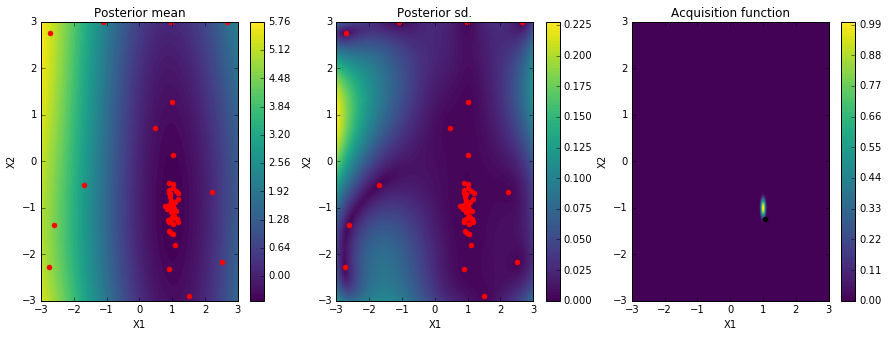

In [19]:
solver.plot_acquisition()

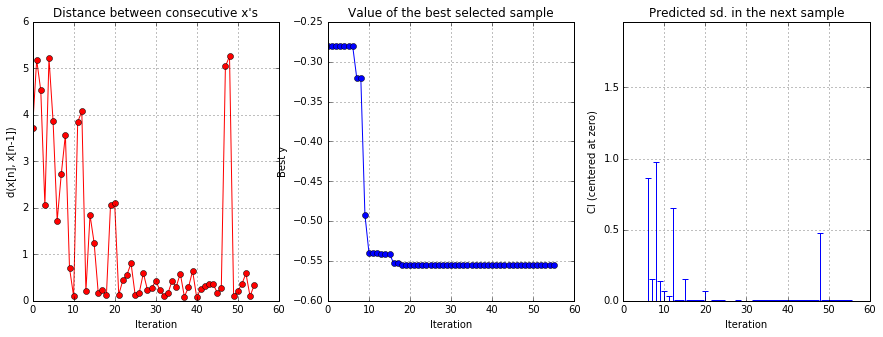

In [20]:
solver.plot_convergence()

In [21]:
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0, 0])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

('GP MLE =', array([ 1.0024545 , -1.00181529]))


Here we plot the posterior mean of the Gaussian Process surrogate learned by the Bayesian Optimization algorithm.

In [23]:
# Plot GP contours
A.set_value(true_A)
B.set_value(true_B)

bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16),
          (exact_MLE[1] - 0.5, exact_MLE[1] + 0.5)]

As = np.linspace(bounds[0][0], bounds[0][1], 100)
Bs = np.linspace(bounds[1][0], bounds[1][1], 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1), BB.reshape(-1, 1)))

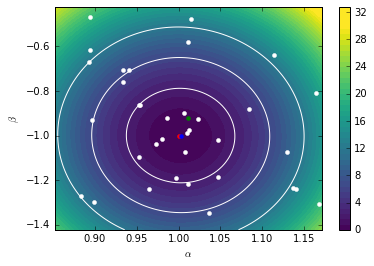

In [25]:
from scipy.stats import chi2
gp_contours, _= solver.model.predict(X)
gp_contours = 2. * (gp_contours - r.fun) * len(X_true)  # Rescale

cs = plt.contour(As, Bs, gp_contours.reshape(AA.shape), 
                 levels=[chi2.ppf(0.683, df=2), 
                         chi2.ppf(0.9545, df=2),
                         chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, gp_contours.reshape(AA.shape), 50, vmin=0, vmax=30)
cb = plt.colorbar()

plt.plot(solver.X[:, 0], solver.X[:, 1], 'w.', markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([exact_MLE[0]], [exact_MLE[1]], "g.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)

plt.axis((bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")

#plt.savefig("fig4b.pdf")
plt.show()

Finally, we plot the approximate likelihood from a grid scan. Statistical fluctuations in the calibration lead to some noise in the scan. The Gaussian Process surrogate above smooths out this noise providing a smoother approximate likelihood.

In [27]:
# Contours of the approximated LR
A.set_value(true_A)
B.set_value(true_B)

bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16),
          (exact_MLE[1] - 0.5, exact_MLE[1] + 0.5)]

As = np.linspace(bounds[0][0], bounds[0][1], 16)
Bs = np.linspace(bounds[1][0], bounds[1][1], 16)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

In [28]:
approx_contours = np.zeros(len(X))

i = 0
for a in As:    
    for b in Bs:
        approx_contours[i] = objective([a, b]) 
        i += 1
        
approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)

[0.85185167406251494, -1.4221311870377324]
[0.85185167406251494, -1.3554645203710658]
[0.85185167406251494, -1.2887978537043991]
[0.85185167406251494, -1.2221311870377325]
[0.85185167406251494, -1.1554645203710658]
[0.85185167406251494, -1.0887978537043992]
[0.85185167406251494, -1.0221311870377323]
[0.85185167406251494, -0.95546452037106577]
[0.85185167406251494, -0.88879785370439912]
[0.85185167406251494, -0.82213118703773247]
[0.85185167406251494, -0.75546452037106582]
[0.85185167406251494, -0.68879785370439917]
[0.85185167406251494, -0.6221311870377324]
[0.85185167406251494, -0.55546452037106575]
[0.85185167406251494, -0.4887978537043991]
[0.85185167406251494, -0.42213118703773245]
[0.87318500739584826, -1.4221311870377324]
[0.87318500739584826, -1.3554645203710658]
[0.87318500739584826, -1.2887978537043991]
[0.87318500739584826, -1.2221311870377325]
[0.87318500739584826, -1.1554645203710658]
[0.87318500739584826, -1.0887978537043992]
[0.87318500739584826, -1.0221311870377323]
[0.8

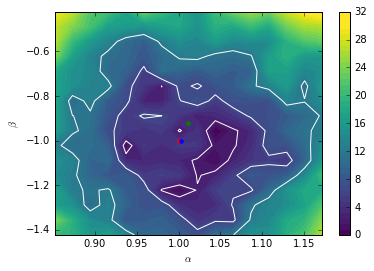

In [30]:
plt.contour(As, Bs, approx_contours.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, approx_contours.reshape(AA.shape).T, 50, vmin=0, vmax=30)
plt.colorbar()

plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([exact_MLE[0]], [exact_MLE[1]], "g.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)

plt.axis((bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")

#plt.savefig("fig4c.pdf")
plt.show()

# Simple ABC estimation

In [43]:
import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
sys.path.insert(0, cmd_folder + '/abc/SIMPLE-ABC')

In [50]:
from simple_abc import Model, basic_abc, pmc_abc
from scipy import stats

In [1]:

class MyModel(Model):
    
    #This method initializes the model object. In this case it does nothing, but you can have you model 
    #do something when the model object is created, like read in a table of something. 
    def __init__(self):
        pass
    
    #This is the method that draws from you prior. In this example it draws from frozen scipy.stats 
    #distributions that are set with the Model.set_priors method.
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta
    
    #The method that generates the synthetic data sets.
    def generate_data(self, theta, size=100000):
        A.set_value(theta[0])
        B.set_value(theta[1])
        return p0.rvs(n_samples = size)
    
    #The method that computes your summary statistics, for a Gaussian we just need mu and sigma
    def summary_stats(self, data):
        mu = stats.mstats.mquantiles(data, 
                                     prob=[0.15,0.3,0.45,0.6,0.75,0.9], axis=0)
        
        return (mu)
    
    #And finally the distance function. We are just going to use the euclidean distance 
    #from our observed summary stats
    def distance_function(self, data, synth_data):
        return np.mean(np.abs(data - synth_data))


SyntaxError: invalid syntax (<ipython-input-1-605ff575c773>, line 23)

In [111]:
loc_0, scale_0 = 0.5*(bounds[0][0]+bounds[0][1]), 0.5*(bounds[0][1]-bounds[0][0])
loc_1, scale_1 = 0.5*(bounds[1][0]+bounds[1][1]), 0.5*(bounds[1][1]-bounds[1][0])

print(loc_0, scale_0, loc_1, scale_1)

#Set a random seed 
np.random.seed(1234)

#Initialize our model object
model = MyModel()

#Make our "observed" data. Let's use the model's generate_data method.
data = model.generate_data([true_A, true_B], size=500)

#Now we need to set the prior distributions. We were clever and set up our draw theta method to call 
#frozen scipy.stats objects, so we jest need to give the model our prior distributions 
model.set_prior([stats.uniform(loc=loc_0,scale=scale_0),
                stats.uniform(loc=loc_1, scale=scale_1)])

#And while we are at it, we will give the model our observed data as well
model.set_data(data)


(1.011851674062515, 0.15999999999999998, -0.92213118703773245, 0.5)


In [112]:
posterior = basic_abc(model, data, min_samples=50, epsilon=1)

(0.85185167406251494, 1.1718516740625149)

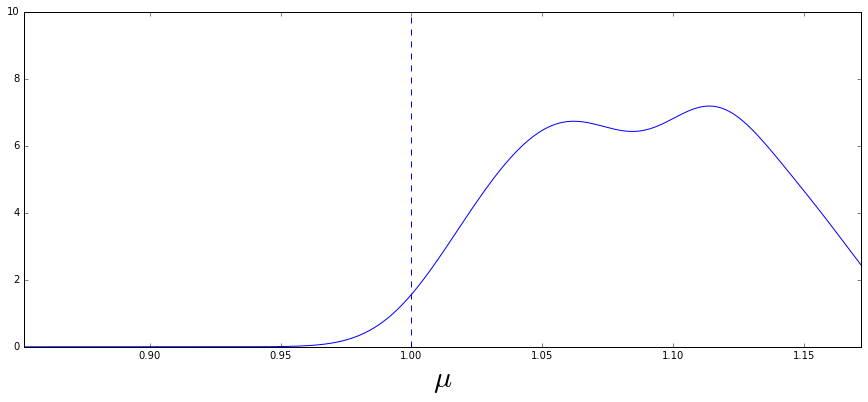

In [113]:
mu = posterior[0][0]

mukde = stats.gaussian_kde(mu)

plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace=0.2)
plt.subplot(111)
#plt.hist(mu,normed=True)
x = np.linspace(bounds[0][0],bounds[0][1],1000)
plt.plot(x, mukde(x))
plt.axvline(true_A, ls="--")
plt.xlabel(r"$\mu$", fontsize=30)
plt.ylim(0,10)
plt.xlim(bounds[0][0],bounds[0][1])

In [114]:
pmc_posterior = pmc_abc(model, data, epsilon_0=1, min_samples=50, steps=15)

Starting step 0
Starting step 1
Starting step 2
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 7
Starting step 8
Starting step 9
Starting step 10
Starting step 11
Starting step 12
Starting step 13
Starting step 14


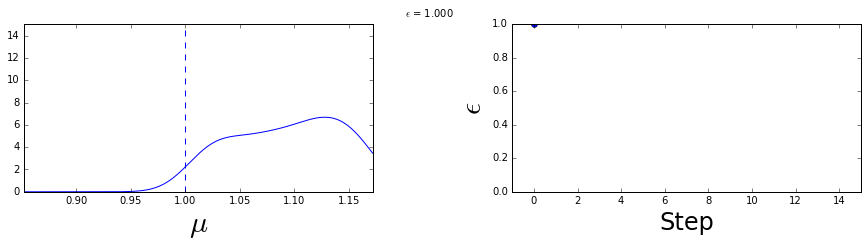

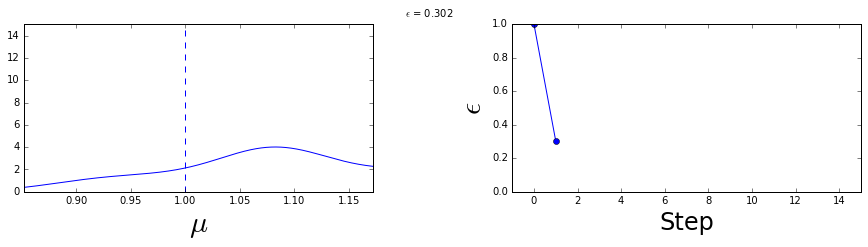

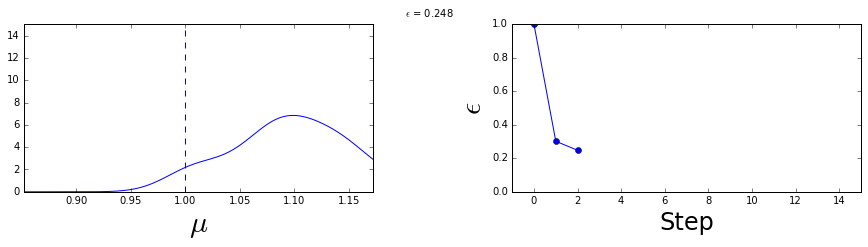

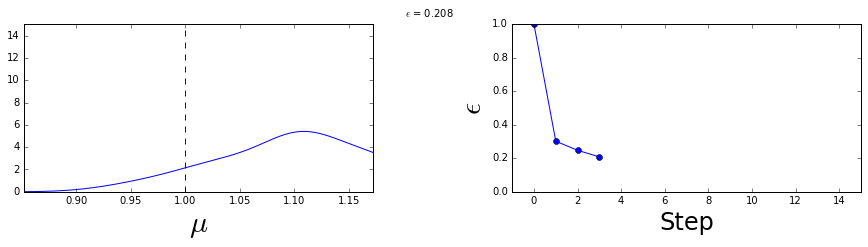

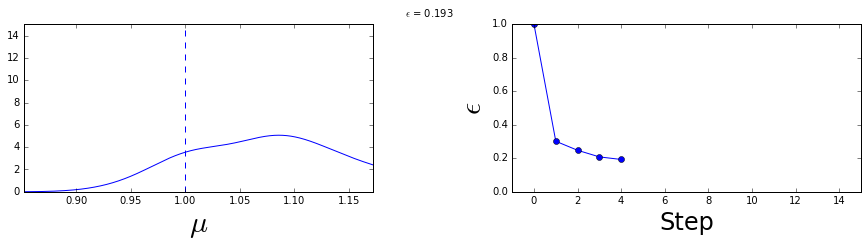

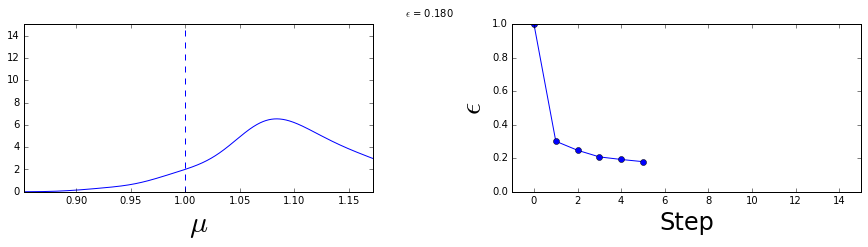

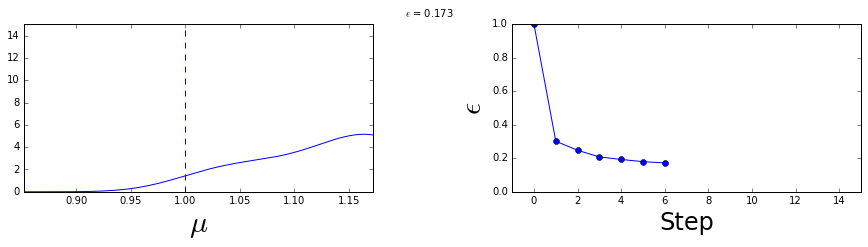

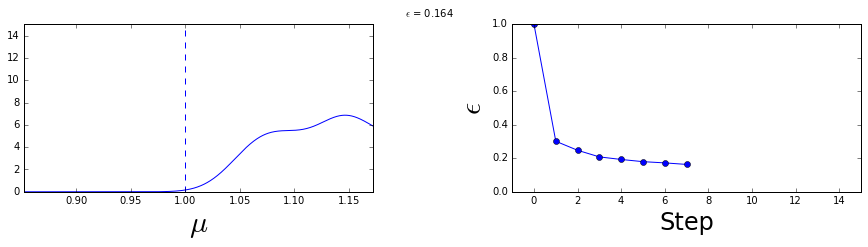

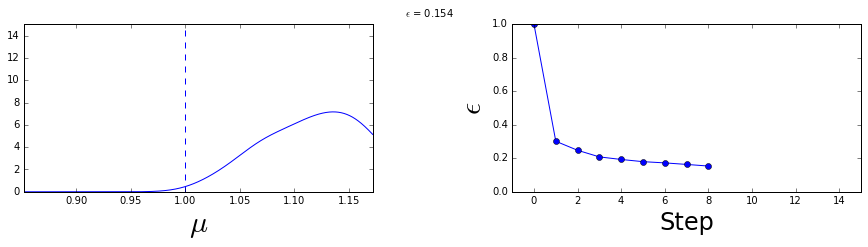

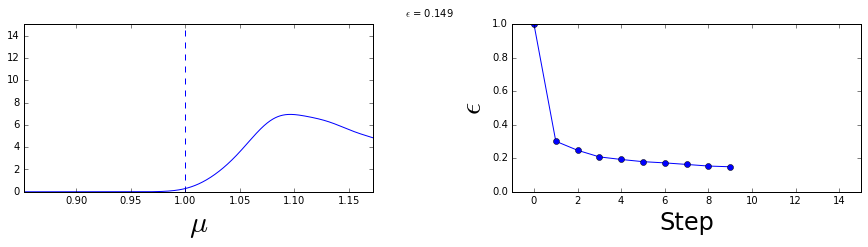

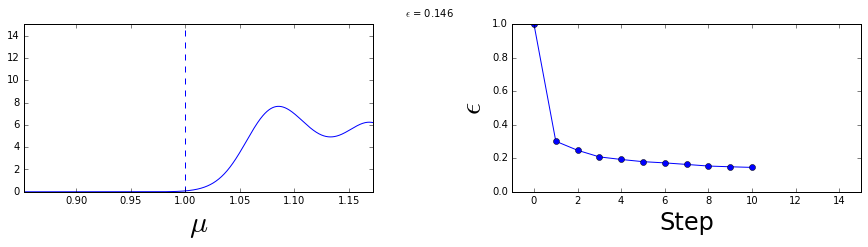

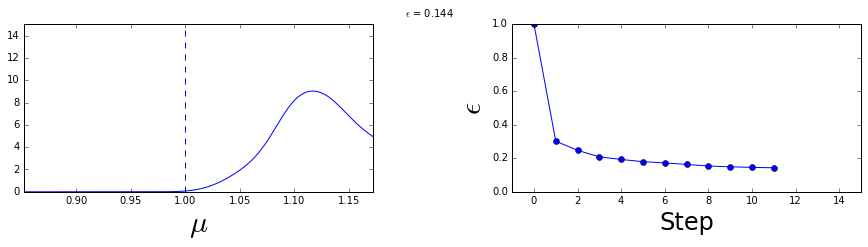

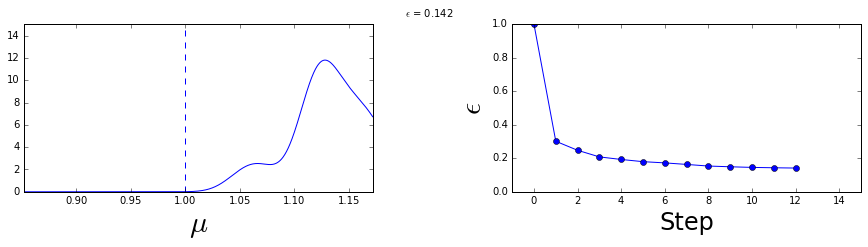

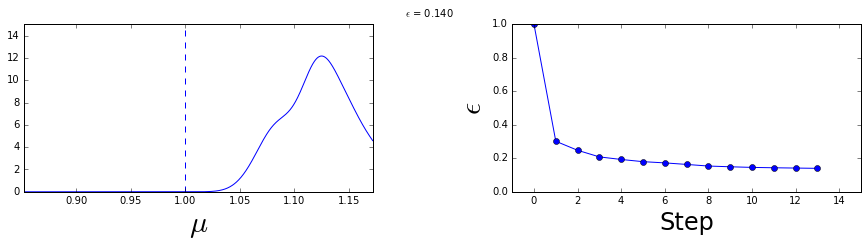

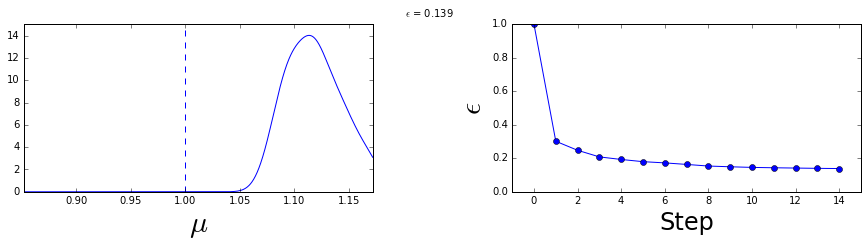

In [116]:
eps = []
for i in pmc_posterior:
    eps.append(i['epsilon'])
    mu = i[0][0]

    mukde = stats.gaussian_kde(mu)
    
    plt.figure(figsize=(15,3))
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(r'$\epsilon$ = {:.3f}'.format(i['epsilon']))
    plt.subplot(121)
    x = np.linspace(bounds[0][0],bounds[0][1],1000)
    plt.plot(x, mukde(x))
    plt.axvline(true_A, ls='--')
    plt.ylim(0,15)
    plt.xlim(bounds[0][0],bounds[0][1])
    plt.xlabel(r"$\mu$", fontsize=30)

    plt.subplot(122)

    plt.plot(eps,'-o')
    plt.xlabel('Step', fontsize=24)
    plt.ylabel(r'$\epsilon$', fontsize=30)
    plt.xlim(-1,15)
    plt.ylim(0,1)

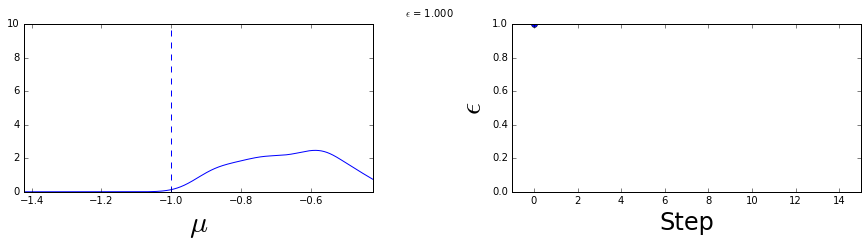

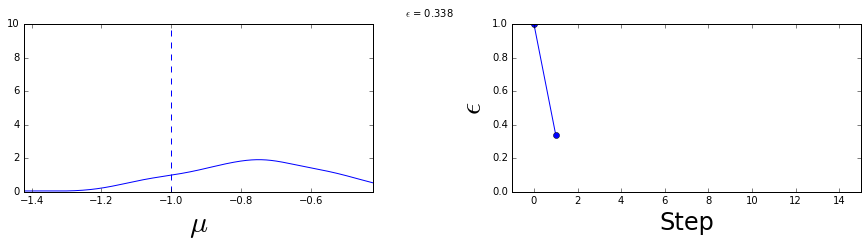

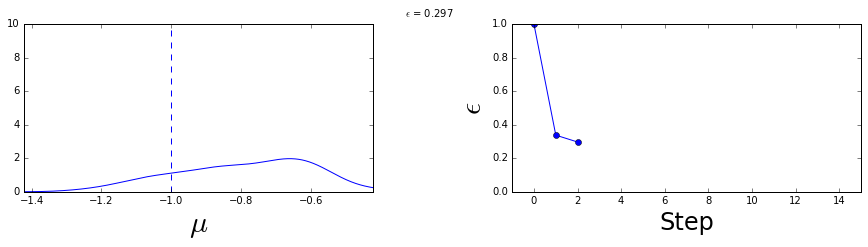

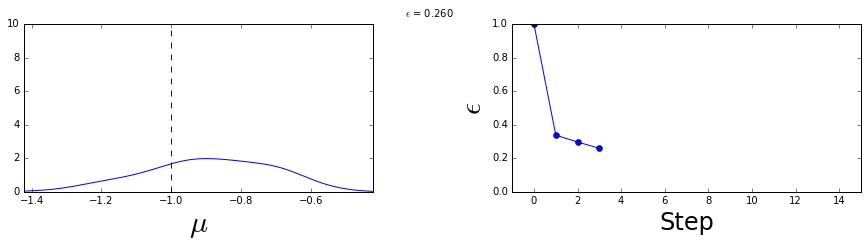

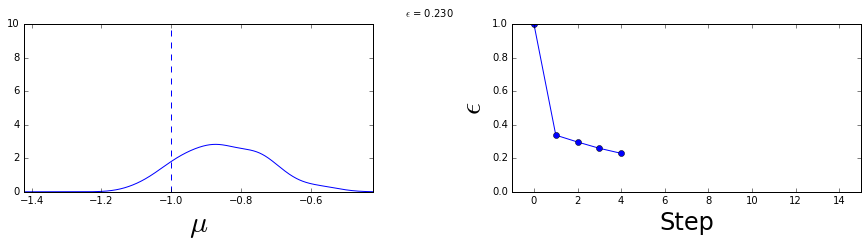

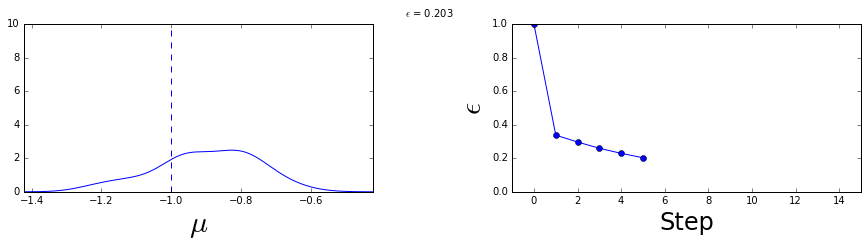

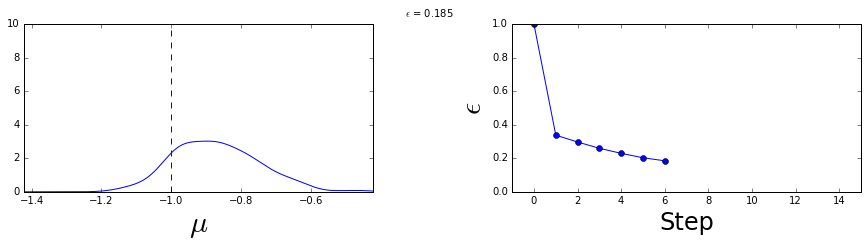

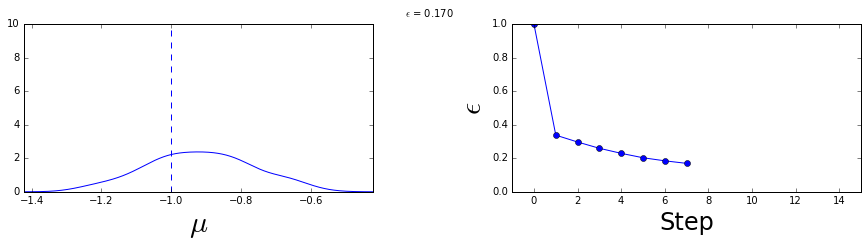

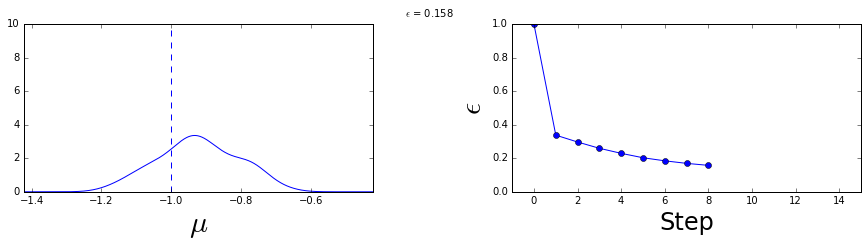

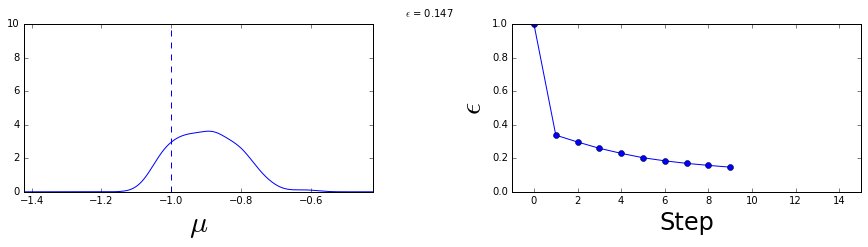

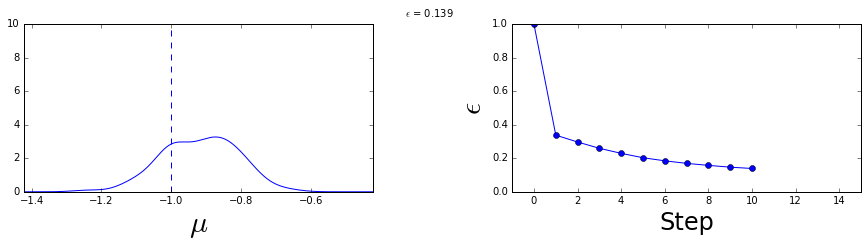

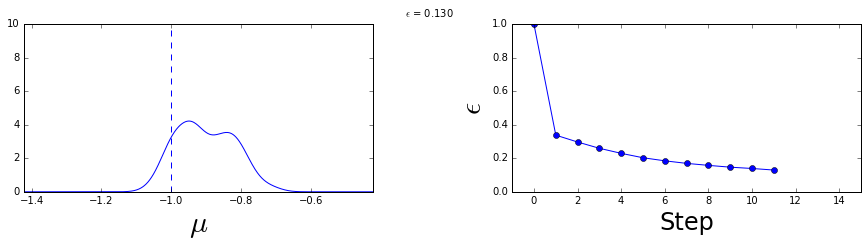

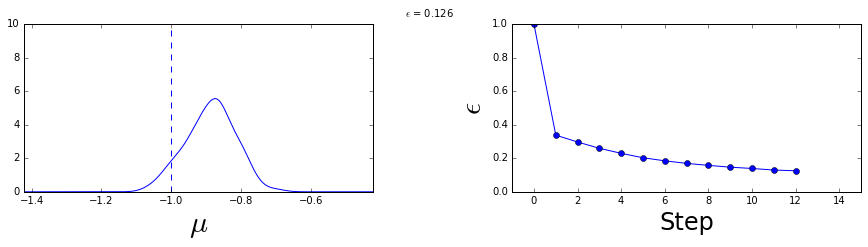

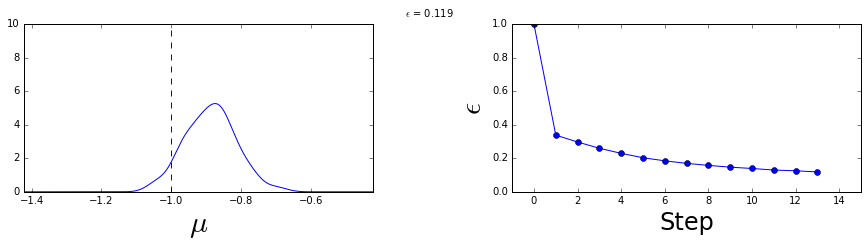

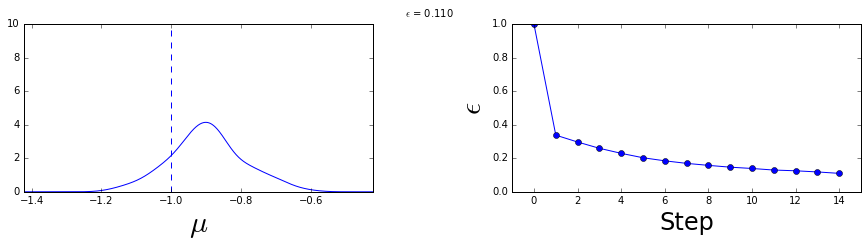

In [100]:
eps = []
for i in pmc_posterior:
    eps.append(i['epsilon'])
    mu = i[0][1]

    mukde = stats.gaussian_kde(mu)
    
    plt.figure(figsize=(15,3))
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(r'$\epsilon$ = {:.3f}'.format(i['epsilon']))
    plt.subplot(121)
    x = np.linspace(bounds[1][0],bounds[1][1],1000)
    plt.plot(x, mukde(x))
    plt.axvline(true_B, ls='--')
    plt.ylim(0,10)
    plt.xlim(bounds[1][0],bounds[1][1])
    plt.xlabel(r"$\mu$", fontsize=30)

    plt.subplot(122)

    plt.plot(eps,'-o')
    plt.xlabel('Step', fontsize=24)
    plt.ylabel(r'$\epsilon$', fontsize=30)
    plt.xlim(-1,15)
    plt.ylim(0,1)